In [1]:
import torch
import os
import numpy as np
from IPython.display import clear_output
from pathlib import Path
import time
import cv2
from itertools import product
import pandas as pd
from torchvision import transforms, models

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
DEVICE = torch.device("cuda")

CUDA is available!  Training on GPU ...


In [2]:
# установка директории с данными на gdrive
%cd drive/My\ Drive/baseline_NTA/data/

/content/drive/My Drive/baseline_NTA/data


In [3]:
TRAIN_DIR = Path('train')
TEST_DIR = Path('test')

test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
train_files = torch.load('train_files.txt')
val_files = torch.load('val_files.txt')

df = pd.read_csv(os.path.join(TRAIN_DIR, 'landmarks.csv'))

In [4]:
def scale(img, output_size):
  h, w, _ = img.shape
  f_y = output_size / h
  f_x = output_size / w
  scaled_image = cv2.resize(img, None, fx=f_x, fy=f_y, interpolation=cv2.INTER_AREA)
  return scaled_image, np.array([f_x, f_y])

def restore_landmarks_batch(batch_landmarks, fs):
  batch_len = batch_landmarks.shape[0]
  batch_landmarks = batch_landmarks.reshape(batch_len, -1, 2) / fs.reshape(-1, 1, 2)

  return batch_landmarks.reshape(batch_len, -1)

In [5]:
class LandmarksDataset(Dataset):
  def __init__(self, files, is_train=True, is_val=False):
    super().__init__()
    self.files = sorted(files)
    self.is_train = is_train
    self.is_val = is_val
    self.scale_size = 256
    if self.is_train:
      self.names = list(map(lambda x: str(x).split('/')[-1], self.files))
      self.df = df[df['filename'].isin(self.names)].sort_values('filename')
      self.landmarks = np.array(self.df.iloc[:, 1:], dtype=np.int16).reshape(len(self.df), -1, 2)
      
  def __getitem__(self, idx):
    sample = {}
    transform = transforms.Compose([
          transforms.ColorJitter(),            
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      ])
    if self.is_val:
      transform = transforms.Compose([            
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    image = cv2.cvtColor(cv2.imread(str(self.files[idx])), cv2.COLOR_BGR2RGB)
    image, sample['f'] = scale(image, self.scale_size)
    image = image / 255
    sample['image'] = transform(image).float()
    if self.is_train:
      landmarks = self.landmarks[idx]
      sample['landmarks'] = (landmarks * sample['f']).ravel()
     
    return sample

  def __len__(self):
      return len(self.files)

In [6]:
def train_epoch(model, criterion, dataloader, optimizer):
  model.train(True)
  train_loss = []
  for batch in dataloader:
    images = batch["image"].to(DEVICE)  
    landmarks = batch['landmarks'].to(DEVICE)

    model_landmarks = model(images)
    loss = criterion(model_landmarks, landmarks.to(dtype=torch.float32), reduction="mean")
    train_loss.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [7]:
def eval_epoch(model, criterion, val_loader):
  model.eval()
  val_loss = []
  for batch in val_loader:
    images, landmarks = batch["image"].to(DEVICE), batch["landmarks"]
    fs = batch['f']
    with torch.no_grad():
      pred_landmarks = model(images).cpu()
    model_landmarks = restore_landmarks_batch(pred_landmarks, fs)
    data_landmarks = restore_landmarks_batch(landmarks, fs)
    loss = criterion(model_landmarks, data_landmarks, reduction="mean")
    val_loss.append(loss.item())

  return np.mean(val_loss, dtype=np.float64)

In [8]:
def train(model, train_data, val_data, epochs, batch_size):
  train_loader = DataLoader(LandmarksDataset(train_data), batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(LandmarksDataset(val_data, is_val=True), batch_size=batch_size)
  val_mse = []
  criterion = nn.functional.mse_loss
  opt = torch.optim.Adam(model.parameters(), lr=1e-4, amsgrad=True)
  # scheduler = torch.optim.lr_scheduler.StepLR(opt, 2, gamma=0.2)
  best_mse = 1000
  best_model_wts = model.state_dict()
  for i in range(epochs):
    since = time.time()

    train_epoch(model, criterion, train_loader, opt)
    # scheduler.step()
    val_epoch_mse = eval_epoch(model, criterion, val_loader)

    val_mse.append(val_epoch_mse)
    if best_mse > val_epoch_mse:
      best_mse = val_epoch_mse
      best_model_wts = model.state_dict()
      torch.save(best_model_wts, 'best_weights_resnext.pth')
    
    clear_output()
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(val_mse)), val_mse, label=f'Test,  mse: {val_epoch_mse}')
    time_elapsed = time.time() - since
    plt.title(f'Epoch {i}, time for epoch:{time_elapsed // 60 :.0f}m, {time_elapsed % 60 :.0f}s')
    plt.legend(loc='best')
    plt.show()
  model.load_state_dict(best_model_wts)
  return model

In [9]:
model = models.resnext101_32x8d(pretrained=True)

In [12]:
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 388)
model.load_state_dict(torch.load('best_weights_resnext.pth'))
model = model.cuda()

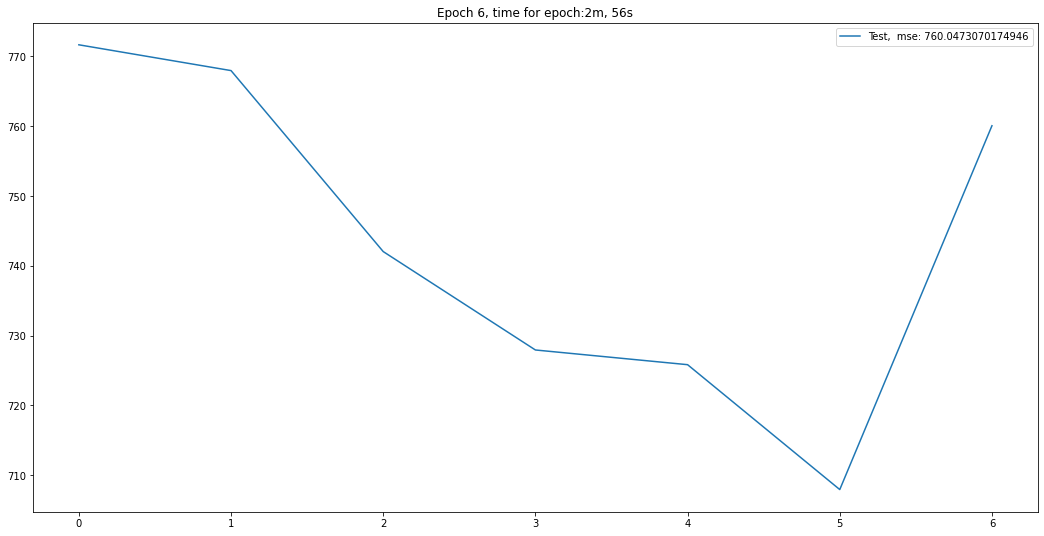

KeyboardInterrupt: ignored

In [11]:
model = train(model, train_files, val_files, 20, 16)

In [13]:
eval_epoch(model, nn.functional.mse_loss, DataLoader(LandmarksDataset(val_files), batch_size=16))

707.9379551424299

In [14]:
def create_submission(path_to_data, test_predictions, path_to_submission_file, header):
    test_dir = os.path.join(path_to_data)

    output_file = path_to_submission_file
    wf = open(output_file, 'w')
    wf.write(header)

    mapping_path = os.path.join(test_dir, 'test_points.csv')
    mapping = pd.read_csv(mapping_path, delimiter=',')

    for i, row in mapping.iterrows():
        file_name = row[0]

        point_index_list = np.array(eval(row[1]))
        points_for_image = test_predictions[i]
        needed_points = points_for_image[point_index_list].astype(np.int)
        wf.write(file_name + ',' + ','.join(map(str, needed_points.reshape(2 * len(point_index_list)))) + '\n')

def predict(model, loader, NUM_PTS, device):
    model.eval()
    predictions = np.zeros((len(loader.dataset), NUM_PTS, 2))
    for i, batch in enumerate(tqdm.tqdm(loader, total=len(loader), desc="test prediction...")):
        images = batch["image"].to(device)

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
             # B x NUM_PTS x 2
        

        fs = batch["f"]  # B
        # print(fs[0])
        # print(pred_landmarks[0])
        prediction = restore_landmarks_batch(pred_landmarks, fs).reshape((len(pred_landmarks), NUM_PTS, 2))  # B x NUM_PTS x 2
        # print(prediction[0])
        predictions[i * loader.batch_size: (i + 1) * loader.batch_size] = prediction

    return predictions

In [15]:
import tqdm

In [16]:
NUM_PTS=194
test_predictions = predict(model, DataLoader(LandmarksDataset(test_files, is_train=False, is_val=True), batch_size=16), NUM_PTS, DEVICE)
SUBMISSION_HEADER = "file_name,Point_M0_X,Point_M0_Y,Point_M1_X,Point_M1_Y,Point_M2_X,Point_M2_Y,Point_M3_X,Point_M3_Y,Point_M4_X,Point_M4_Y,Point_M5_X,Point_M5_Y,Point_M6_X,Point_M6_Y,Point_M7_X,Point_M7_Y,Point_M8_X,Point_M8_Y,Point_M9_X,Point_M9_Y,Point_M10_X,Point_M10_Y,Point_M11_X,Point_M11_Y,Point_M12_X,Point_M12_Y,Point_M13_X,Point_M13_Y,Point_M14_X,Point_M14_Y,Point_M15_X,Point_M15_Y,Point_M16_X,Point_M16_Y,Point_M17_X,Point_M17_Y,Point_M18_X,Point_M18_Y,Point_M19_X,Point_M19_Y,Point_M20_X,Point_M20_Y,Point_M21_X,Point_M21_Y,Point_M22_X,Point_M22_Y,Point_M23_X,Point_M23_Y,Point_M24_X,Point_M24_Y,Point_M25_X,Point_M25_Y,Point_M26_X,Point_M26_Y,Point_M27_X,Point_M27_Y,Point_M28_X,Point_M28_Y,Point_M29_X,Point_M29_Y\n"

create_submission(TEST_DIR, test_predictions, f"submit.csv", SUBMISSION_HEADER)

test prediction...: 100%|██████████| 21/21 [00:25<00:00,  1.23s/it]
